# Import Libraries/Packages & Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
proc = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

## Set Working directory
## Load benign data, drop unwanted columns
 

In [2]:
fulldata = pd.read_csv('idsdata\CICIDS_ALLATTACKS.csv')
fulldata['Label'].value_counts()

Label
Benign                      4263051
DoS attacks-Hulk             439126
DDOS attack-HOIC             360833
Bot                          285763
FTP-BruteForce               193354
SSH-Bruteforce               187589
Infilteration                152874
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         39924
DoS attacks-Slowloris          2724
DDOS attack-LOIC-UDP           1730
Attack                          544
Name: count, dtype: int64

In [9]:
## https://www.researchgate.net/figure/Attack-Types-in-CSE-CIC-IDS2018-dataset_tbl1_333894962

mapping= {'SSH-Bruteforce': 'Brute-force',
          'FTP-BruteForce': 'Brute-force',
          ################ Brute-force 
          
          'Brute Force -XSS': 'Web attack',
          'Brute Force -Web': 'Web attack',
          'SQL Injection': 'Web attack',
          ################ Web attack 
          
          'DoS attacks-Hulk': 'DoS attack',
          'DoS attacks-SlowHTTPTest': 'DoS attack',
          'DoS attacks-Slowloris': 'DoS attack',
          'DoS attacks-GoldenEye': 'DoS attack',
          ################ DoS attack 
          
          'DDOS attack-HOIC': 'DDoS attack',
          'DDOS attack-LOIC-UDP': 'DDoS attack',
          'DDoS attacks-LOIC-HTTP': 'DDoS attack',
          ################ DDoS attack 
          
          'Bot': 'Botnet',
          ################ Botnet 
          
          'Infilteration': 'Infilteration',
          ################ Infilteration 
          
          'Benign': 'Benign',
          'Label': 'Benign',
          ################ Infilteration 
    }

def transform_multi_label(df):
    print(df['Label'].value_counts())
    df['Label'] = df['Label'].map(mapping) 
    return df

In [10]:
fulldata = transform_multi_label(fulldata)

Label
Benign                      4263051
DoS attacks-Hulk             439126
DDOS attack-HOIC             360833
Bot                          285763
FTP-BruteForce               193354
SSH-Bruteforce               187589
Infilteration                152874
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         39924
DoS attacks-Slowloris          2724
DDOS attack-LOIC-UDP           1730
Attack                          544
Name: count, dtype: int64


In [11]:
fulldata['Label'].value_counts()

Label
Benign           4263051
DoS attack        621664
Brute-force       380943
DDoS attack       362563
Botnet            285763
Infilteration     152874
Name: count, dtype: int64

In [12]:
train_datas = {}
test_datas = {}
train_datas_soft = {}
train_datas_soft_no_benign = {}
sel_labels = []
mixed_data = pd.DataFrame()
for i in fulldata['Label'].unique():
    if fulldata[fulldata['Label'] == i].shape[0] > 100000:
        print(i)
        sel_labels.append(i)
        train_datas[i] = fulldata[fulldata['Label'] == i][:100000]
        test_datas[i] = fulldata[fulldata['Label'] == i][100000:110000]
        mixed_data = pd.concat([mixed_data, fulldata[fulldata['Label'] == i][110000:120000]], axis=0)
        train_datas_soft_no_benign[i] = fulldata[fulldata['Label'] == i][:100000]
        if i != 'Benign':
            train_datas_soft[i] = pd.concat([fulldata[fulldata['Label'] == 'Benign'][50000:100000], fulldata[fulldata['Label'] == i][50000:100000]], axis=0)

Benign
DDoS attack
DoS attack
Brute-force
Botnet
Infilteration


In [13]:
for i in train_datas:
    print(train_datas[i])

        Dst Port  Protocol  Timestamp  Flow Duration  Tot Fwd Pkts  \
0       0.808813  0.000000   0.048583   3.292809e-01      0.500000   
2       0.000809  1.000000   0.877752   2.041667e-06      0.000000   
3       0.001221  0.352941   0.059168   1.150000e-05      0.004619   
4       0.000809  1.000000   0.604898   5.883339e-06      0.000000   
5       0.406369  0.352941   0.283270   2.500003e-07      0.001333   
...          ...       ...        ...            ...           ...   
142828  0.001221  0.352941   0.127665   6.825001e-06      0.004619   
142830  0.000809  1.000000   0.373273   1.119534e-03      0.001919   
142831  0.000000  0.000000   0.846084   6.781242e-03      0.011364   
142832  0.906842  0.352941   0.049376   1.001667e-05      0.000013   
142833  0.051714  0.352941   0.702169   1.460400e-02      0.016166   

        Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
0           0.300000         0.564614         0.137019         1.000000   
2        

In [14]:
from sklearn.preprocessing import OneHotEncoder
labelencoder = OneHotEncoder()
labels = np.array(sel_labels).reshape(-1,1)
labelencoder.fit(labels)
encodedlabels = (labelencoder.transform(labels).todense()).tolist()
print(encodedlabels)
dikt = {}
for i in range(len(encodedlabels)):
    dikt[labels[i][0]] = encodedlabels[i]
dikt

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]


{'Benign': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DDoS attack': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 'DoS attack': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 'Brute-force': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 'Botnet': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 'Infilteration': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]}

In [15]:
"""for i,row in soft_data.iterrows():
    soft_data.at[i,'Label'] = dikt[soft_data.at[i,'Label']]"""

"for i,row in soft_data.iterrows():\n    soft_data.at[i,'Label'] = dikt[soft_data.at[i,'Label']]"

In [16]:
del fulldata

In [17]:
mixed_data = mixed_data.sample(frac=1).reset_index(drop=True)
mixed_data_labels = list(mixed_data['Label'])
mixed_data.drop(['Label'], axis=1, inplace=True)
mixed_data = mixed_data.to_numpy()
for i in train_datas:
    train_datas[i].drop(['Label'], axis=1, inplace=True)
    test_datas[i].drop(['Label'], axis=1, inplace=True)
    train_datas[i] = train_datas[i].sample(frac=1).reset_index(drop=True)
    test_datas[i] = test_datas[i].sample(frac=1).reset_index(drop=True)
    train_datas[i] = train_datas[i].to_numpy()
    test_datas[i] = test_datas[i].to_numpy()

In [18]:
train_datas_soft_labels = {}
for i in train_datas_soft:
    train_datas_soft[i] = train_datas_soft[i].sample(frac=1).reset_index(drop=True)
    train_datas_soft_labels[i] = list(train_datas_soft[i]['Label'])
    train_datas_soft[i].drop(['Label'], axis=1, inplace=True)
    train_datas_soft[i] = train_datas_soft[i].to_numpy()

In [19]:
train_datas_soft_no_benign_labels = {}
for i in train_datas_soft_no_benign:
    train_datas_soft_no_benign[i] = train_datas_soft_no_benign[i].sample(frac=1).reset_index(drop=True)
    train_datas_soft_no_benign_labels[i] = list(train_datas_soft_no_benign[i]['Label'])
    train_datas_soft_no_benign[i].drop(['Label'], axis=1, inplace=True)
    train_datas_soft_no_benign[i] = train_datas_soft_no_benign[i].to_numpy()

In [20]:
train_datas_soft_labels_encoded = {}
for i in train_datas_soft_labels:
    train_datas_soft_labels_encoded[i] = []
    for j in train_datas_soft_labels[i]:
        train_datas_soft_labels_encoded[i].append(dikt[j])

In [21]:
train_datas_soft_no_benign_labels_encoded = {}
for i in train_datas_soft_no_benign_labels:
    train_datas_soft_no_benign_labels_encoded[i] = []
    for j in train_datas_soft_no_benign_labels[i]:
        train_datas_soft_no_benign_labels_encoded[i].append(dikt[j])

In [22]:
mixed_data_labels_encoded = []
for i in mixed_data_labels:
    mixed_data_labels_encoded.append(dikt[i])

In [23]:
#loading data into pytorch dataloader as train and test
devices = []
batch_size = 128
train_loader = {}
for i in train_datas:
  train_loader[i] = torch.utils.data.DataLoader(train_datas[i], batch_size = batch_size, shuffle=True)
  devices.append(i)

In [24]:
"""
train_soft_loader = {}
for i in train_datas_soft:
  train_soft_loader[i] = torch.utils.data.DataLoader(train_datas_soft[i], batch_size = batch_size)
"""

'\ntrain_soft_loader = {}\nfor i in train_datas_soft:\n  train_soft_loader[i] = torch.utils.data.DataLoader(train_datas_soft[i], batch_size = batch_size)\n'

In [25]:
"""
train_soft_no_benign_loader = {}
for i in train_datas_soft_no_benign:
  train_soft_no_benign_loader[i] = torch.utils.data.DataLoader(train_datas_soft_no_benign[i], batch_size = batch_size)
"""

'\ntrain_soft_no_benign_loader = {}\nfor i in train_datas_soft_no_benign:\n  train_soft_no_benign_loader[i] = torch.utils.data.DataLoader(train_datas_soft_no_benign[i], batch_size = batch_size)\n'

In [26]:
#initialising config variables
num_clients = len(train_loader)      # Number of clients
num_selected = len(train_loader)    # Typically, num_selected is around 30–40% of the num_clients.
#baseline_num = 1000  # choose some data from the train set to retrain the data from trained model
num_rounds = 5  #100      # Total number of communication rounds for the global model to train.
epochs = 20          # for train client model
#retrain_epochs = 3  # Total number of retraining rounds on the global server after receiving the model weights
                      # from all the clients that participated in the communication round.

## FedAvg / FedAvgM

In [27]:
# aggregates the model weights received from every client
# and updates the global model with updated weights

# FedAvg
def server_aggregate(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    # n = num_selected
    global_dict = global_model.state_dict()
    for k in global_dict.keys(): # calculate average weight/bias --> avg_w/b
        global_dict[k] -= torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    #for model in client_models:
     #   model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

# FedAvgM
def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)    # 592    sum [51, 122, 162, 257]
    n = len(client_models)      # 4 local clients
    global_dict = global_model.state_dict() # weight/bias dict --> {'encoder.0.weight': Tensor with shape torch.Size([86, 115]), 'encoder.0.bias':....} 16 items
    temp = copy.deepcopy(global_dict)       # temporary weight/bias dict
    v = {x:1 for x in copy.deepcopy(global_dict)}   # initialise v

    for i,k in enumerate(global_dict.keys()):
        # calculate average weight/bias --> avg_w/b
        temp[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
        temp_v = 0.9 * v[k] + temp[k]               # v = 0.9v + avg_w/b   momentum=0.9
        global_dict[k] = global_dict[k] - temp_v    # w = w - v
    global_model.load_state_dict(global_dict)

    #for model in client_models:
     #   model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias



In [28]:
# for updates/trains client model on client data
# local training round that takes place for every selected client

def client_update(client_model, optimizer, train_data, epoch=3):
    client_model.train()
    for e in range(epoch):
        running_loss = 0.0
        for data in train_data:
          output = client_model(data.float()) # tensor 115
          optimizer.zero_grad()
          # criterion = nn.MSELoss(reduction='mean')
          # loss = criterion(data.to(proc), output)
          loss = nn.MSELoss(reduction='mean')(data.float().to(proc), output)
          loss.backward()
          optimizer.step()
          # print(loss.item())
          running_loss += loss.item()
        # print(running_loss)
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss
    # return loss.item()



# synchronizes the client model with global weights (before training)

def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())

## Deep Auto-encoder Model

In [29]:
import torch.nn as nn

input_dim = train_loader['Benign'].dataset.shape[1]

class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        
        xavier_gain = nn.init.calculate_gain('tanh')
        
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 64)  
        self.fc3 = nn.Linear(64, 48)
        self.fc4 = nn.Linear(48, 32)
        self.fc5 = nn.Linear(32, 24)
        self.fc6 = nn.Linear(24, 16)
        self.fc7 = nn.Linear(16, 16)
        self.fc8 = nn.Linear(16, 24)
        self.fc9 = nn.Linear(24, 32)
        self.fc10 = nn.Linear(32, 48)
        self.fc11 = nn.Linear(48, 64)
        self.fc12 = nn.Linear(64, input_dim)
        self.fc13 = nn.Linear(input_dim, input_dim)
       
        self.activation = nn.Tanh()
        
        nn.init.xavier_uniform_(self.fc1.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc2.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc3.weight, gain=xavier_gain) 
        nn.init.xavier_uniform_(self.fc4.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc5.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc6.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc7.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc8.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc9.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc10.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc11.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc12.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc13.weight, gain=xavier_gain)
        
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x) 
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x) 
        x = self.fc6(x)
        x = self.activation(x)
        x = self.fc7(x)
        x = self.activation(x)
        x = self.fc8(x) 
        x = self.activation(x)
        x = self.fc9(x)
        x = self.activation(x)
        x = self.fc10(x) 
        x = self.activation(x)
        x = self.fc11(x)
        x = self.activation(x)
        x = self.fc12(x)
        x = self.activation(x)
        x = self.fc13(x)
        return x

In [30]:
global_model = AEModel(input_dim).to(proc)
client_models = {}
for i in devices:
    client_models[i] = AEModel(input_dim).to(proc)
opt = {}
for i in devices:
    opt[i] = optim.SGD(client_models[i].parameters(), lr=0.001, weight_decay=1e-05, momentum=0.9)

In [31]:
"""# Initializing models and optimizer

global_model = AEModel(input_dim).to(proc)
client_models = [AEModel(input_dim).to(proc) for _ in range(num_selected)] # part or all clients
# print(client_models)
for model in client_models:
    model.load_state_dict(global_model.state_dict())

# method_env = {'lr': (0.012, 0.012, 0.012, 0.0005)}
#opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]
# lr_list = [0.012, 0.012, 0.012, 0.00005]
# # opt = [torch.optim.SGD(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05, momentum=0.9) for model in client_models]
# opt = [torch.optim.Adam(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05) for model in client_models]
opt = [torch.optim.Adam(model.parameters(), lr = 0.012, weight_decay=1e-05) for model in client_models]"""

"# Initializing models and optimizer\n\nglobal_model = AEModel(input_dim).to(proc)\nclient_models = [AEModel(input_dim).to(proc) for _ in range(num_selected)] # part or all clients\n# print(client_models)\nfor model in client_models:\n    model.load_state_dict(global_model.state_dict())\n\n# method_env = {'lr': (0.012, 0.012, 0.012, 0.0005)}\n#opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]\n# lr_list = [0.012, 0.012, 0.012, 0.00005]\n# # opt = [torch.optim.SGD(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05, momentum=0.9) for model in client_models]\n# opt = [torch.optim.Adam(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05) for model in client_models]\nopt = [torch.optim.Adam(model.parameters(), lr = 0.012, weight_decay=1e-05) for model in client_models]"

# Training Federated Model

In [32]:
# Train Client Model and Global Model
start_time = time.time()

for r in range(num_rounds): # total number of rounds

    print('\nround: ', r+1)
    # num_selected = random.choice(range(1,num_clients))
    #client_idx = np.random.permutation(num_clients)[:num_selected] # random pick some clients from all clients for train
    #client_idx = list(range(num_clients))
    #print('client_idx: ', client_idx)
    #client_lens = [len(train_loader[devices[idx]]) for idx in client_idx ] # Need to fix this. It is part of server aggregation.
    # client_lens = [len(train_lotrain_loaderader[idx]) for idx in client_idx ]
    #print(client_lens)


    #### client update ####
    loss = 0
    for i in devices:
        # print(i)
        #client_syn(client_models[i], global_model)
        # print(train_loader[devices[client_idx[i]]])
        l = client_update(client_models[i], opt[i], train_loader[i], epochs)
        print('client: ', i, 'loss: ', l)
        loss += l

    #### retraining on the global server ####
    #loss_retrain = 0
    #for i in tqdm(range(num_selected)):
    #    loss_retrain += client_update(client_models[i], opt[i], baseline_data[devices[client_idx[i]]], retrain_epochs)
    #train_loss_global.append(loss_retrain/num_selected)

    """attackclients = []
    for i in devices:
        if i != 'Benign':
            attackclients.append(client_models[i])"""
    
    ### aggregate models ###
    #server_aggregate(global_model, attackclients, client_lens)      # FedAvg
    #server_aggregate_M(global_model, attackclients, client_lens)    # FedAvgM

time_required = time.time() - start_time
print('/nTIME: {}mins'.format(time_required/60))


round:  1
client:  Benign loss:  0.012389159144457344
client:  DDoS attack loss:  0.0003769124607823755
client:  DoS attack loss:  0.0022531238711609378
client:  Brute-force loss:  0.001060966063467095
client:  Botnet loss:  0.0013079113996727035
client:  Infilteration loss:  0.012816474434760068

round:  2
client:  Benign loss:  0.008926485762800402
client:  DDoS attack loss:  0.00032635023224829546
client:  DoS attack loss:  0.0017215620356110517
client:  Brute-force loss:  0.0006478268150648083
client:  Botnet loss:  0.0009671577355613612
client:  Infilteration loss:  0.009249119794286807

round:  3
client:  Benign loss:  0.007332494596729193
client:  DDoS attack loss:  0.0002976805865860824
client:  DoS attack loss:  0.001303711437585685
client:  Brute-force loss:  0.00042849116864295016
client:  Botnet loss:  0.0007918207556940615
client:  Infilteration loss:  0.007389438340959647

round:  4
client:  Benign loss:  0.006329067558755198
client:  DDoS attack loss:  0.000274766288812

In [33]:
for i in devices:
  torch.save(client_models[i],'modelsprocessed/clients/' + i + '.pt')

### Client Test

In [34]:
client_models = {}
for device in devices:
  client_models[device] = torch.load('modelsprocessed/clients/' + device + '.pt')

In [35]:
def quan_thresh(model, dataloader, quantile=0.9):
  model.eval()
  se = []
  
  for batch in dataloader:
    
    for data in batch:
      error = np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2) # len(error) = 66
      se.append(sum(error))
    # Calculate threshold as quantile of errors 
    #thresh = np.quantile(se, quantile, axis=0) #before it was thresh = np.quantile(mse, quantile)
    #errs.append(thresh)
  #thresh = np.quantile(mse, quantile)
  return np.mean(se) + np.std(se), np.quantile(se, quantile), se #before it was np.mean(errs)
  #return thresh

def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_pred)):
        if y_actual[i] == y_pred[i] == 1:
           TP += 1
        if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
           FP += 1
        if y_actual[i] == y_pred[i] == 0:
           TN += 1
        if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
           FN += 1
    return (TP, FP, TN, FN)

In [36]:
thresholds = {}
quans = {}
errors = {}
for device in devices:
    model = client_models[device]
    dataloader = train_loader[device]
    thresholds[device], quans[device], errors[device] = quan_thresh(model, dataloader)
    #thresholds[devices[i]] = quan_recon(model, dataloader)
print(thresholds)

{'Benign': 1.004512070669225, 'DDoS attack': 0.19955984290890444, 'DoS attack': 0.31605447081684407, 'Brute-force': 0.04371884154368161, 'Botnet': 0.2926795432504823, 'Infilteration': 0.862749879954706}


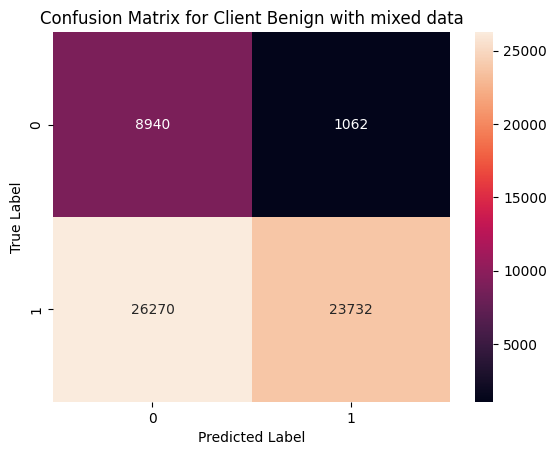

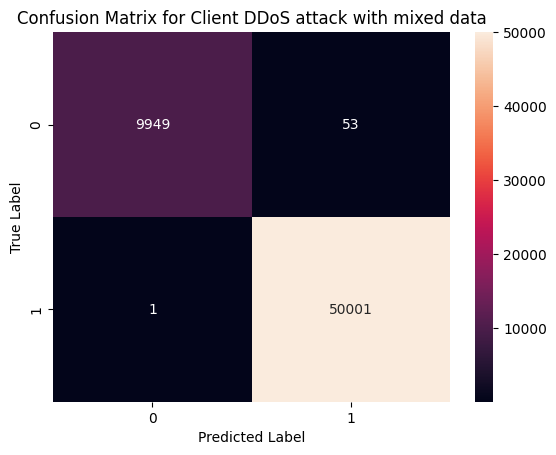

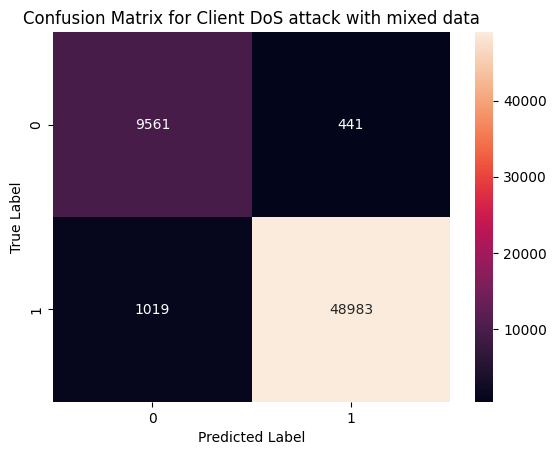

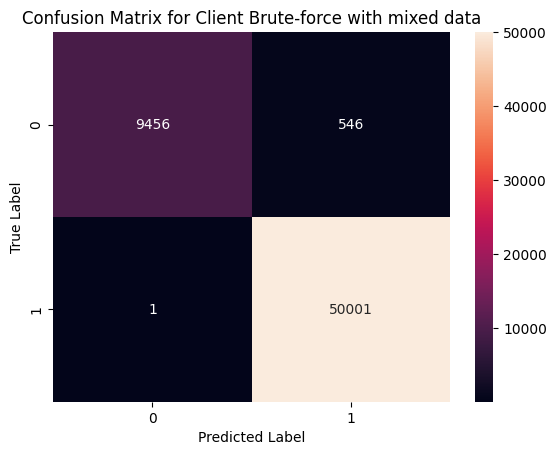

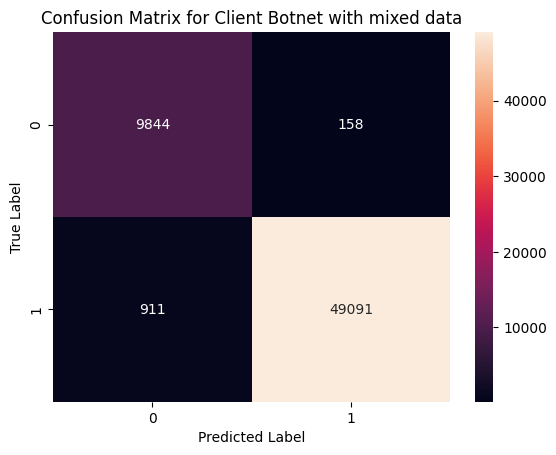

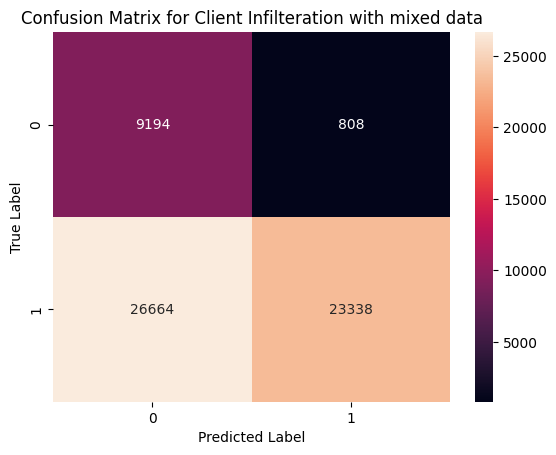

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata, pearsonr
from sklearn.metrics import mutual_info_score
selectedattackbenmix_stats = []
res=[]
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
#  if device == 'Infilteration.csv':
  model = client_models[device]
  model.eval()
  labels = mixed_data_labels
  threshold = thresholds[device]
  temp=[]
  y_true = []
  y_pred = []
  ind = 0
  for data in mixed_data:
      data = torch.Tensor(data)
      error = np.sum(np.power(data.detach().numpy() - model(data).detach().numpy(), 2))
      temp.append(error)
      if device == labels[ind]:
          y_true.append(1)
          y_pred.append(1 if error < threshold else 0)
      else:
          y_true.append(0)
          y_pred.append(0 if error >= threshold else 1)
      #cf.append([coeff, p, device[:-4] == labels[ind]])
      ind += 1
  res.append([device,min(temp),max(temp)])
  TP, FP, TN, FN = perf_measure(y_true, y_pred)
  TP += 1
  FN += 1
  TN += 1
  FP += 1
  conf_matrix = [[TP, FN], [FP, TN]]
  plt.figure() 
  sns.heatmap(conf_matrix, annot=True, fmt="d")
  plt.title("Confusion Matrix for Client " + str(device) +" with mixed data")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")

  acc = (TP+TN) / (TP+TN+FP+FN)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1score = 2 * ((precision * recall) / (precision + recall))

  TPR = round((TP / (TP+FN)), 6)
  # print('TPR is: {}%'.format(TPR))

  FPR = round((FP / (FP + TN)), 6)
  # print('TPR is: {}%'.format(FPR))

  selectedattackbenmix_stats.append([str("Stats for Client " + str(device) +" with mixed data"),acc*100,precision,recall,F1score*100,TPR,FPR])

  #   [['TP', 'FN']
  #   ['FP', 'TN']]

In [38]:
for i in selectedattackbenmix_stats:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

Title: Stats for Client Benign with mixed data
Accuracy: 54.44970335310979
Precision: 0.2539051405850611
Recall: 0.8938212357528494
F1 score : 39.54702291427055
TPR : 0.893821
FPR : 0.525379
Title: Stats for Client DDoS attack with mixed data
Accuracy: 99.91000599960003
Precision: 0.9998994974874372
Recall: 0.9947010597880424
F1 score : 99.72935044105853
TPR : 0.994701
FPR : 2e-05
Title: Stats for Client DoS attack with mixed data
Accuracy: 97.5668288780748
Precision: 0.9036862003780718
Recall: 0.9559088182363528
F1 score : 92.90642308813526
TPR : 0.955909
FPR : 0.020379
Title: Stats for Client Brute-force with mixed data
Accuracy: 99.08839410705953
Precision: 0.9998942582214233
Recall: 0.9454109178164367
F1 score : 97.1889614060332
TPR : 0.945411
FPR : 2e-05
Title: Stats for Client Botnet with mixed data
Accuracy: 98.21845210319312
Precision: 0.9152952115295212
Recall: 0.9842031593681264
F1 score : 94.8499301440478
TPR : 0.984203
FPR : 0.018219
Title: Stats for Client Infilteration wi

## Global model creation

In [41]:
client_models = {}
for device in devices:
  client_models[device] = torch.load('modelsprocessed/clients/' + device + '.pt')

In [42]:

def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x) 
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x) 
        x = self.fc6(x)
        x = self.activation(x)
        x = self.fc7(x)
        x = self.activation(x)
        out = x
        x = self.fc8(x) 
        x = self.activation(x)
        x = self.fc9(x)
        x = self.activation(x)
        x = self.fc10(x) 
        x = self.activation(x)
        x = self.fc11(x)
        x = self.activation(x)
        x = self.fc12(x)
        x = self.activation(x)
        x = self.fc13(x)
        return out

In [43]:
#noise
compressed_outs = {}
compressed_outs_test = {}

for i in client_models:
    model = client_models[i]
    model.__class__.forward = forward
    model.eval()
    dataloader = train_loader[i]
    outs = []
    ind = 0
    flag = False
    for batch in dataloader:
        for data in batch:
            layer_output = model(data.float())
            outs.append(layer_output)
            ind += 1
            if ind == 10000:
                compressed_outs[i] = outs
                outs = []
            elif ind == 20000:
                compressed_outs_test[i] = outs
                flag = True
                break
        if flag:
            break

In [27]:
loader = train_loader['Benign']
for i in client_models:
    model = client_models[i]
    model.eval()
    outs = []
    ind = 0
    flag = False
    for batch in dataloader:
        for data in batch:
            layer_output = model(data.float())
            outs.append(layer_output)
            ind += 1
            if ind == 1000:
                for j in range(len(outs)):
                            compressed_outs.setdefault('not', []).append(outs[j])
                outs = []
            elif ind == 2000:
                for k in range(len(outs)):
                            compressed_outs_test.setdefault('not', []).append(outs[k])
                flag = True
                break
        if flag:
            break

In [44]:
for i in compressed_outs_test.keys():
    print(i,': ',len(compressed_outs_test[i]))

Benign :  10000
DDoS attack :  10000
DoS attack :  10000
Brute-force :  10000
Botnet :  10000
Infilteration :  10000


In [45]:
for i in compressed_outs.keys():
    print(i,': ',len(compressed_outs[i]))


Benign :  10000
DDoS attack :  10000
DoS attack :  10000
Brute-force :  10000
Botnet :  10000
Infilteration :  10000


In [31]:
sel_labels.remove('Benign')
sel_labels.append('not')

In [46]:
sel_labels

['Benign',
 'DDoS attack',
 'DoS attack',
 'Brute-force',
 'Botnet',
 'Infilteration']

In [47]:
from sklearn.preprocessing import OneHotEncoder
labelencoder = OneHotEncoder()
labels = np.array(sel_labels).reshape(-1,1)
labelencoder.fit(labels)
encodedlabels = (labelencoder.transform(labels).todense()).tolist()
dikt = {}
for i in range(len(encodedlabels)):
    dikt[labels[i][0]] = encodedlabels[i]
dikt

{'Benign': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DDoS attack': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 'DoS attack': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 'Brute-force': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 'Botnet': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 'Infilteration': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]}

c:\Users\amenu4aie20110\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


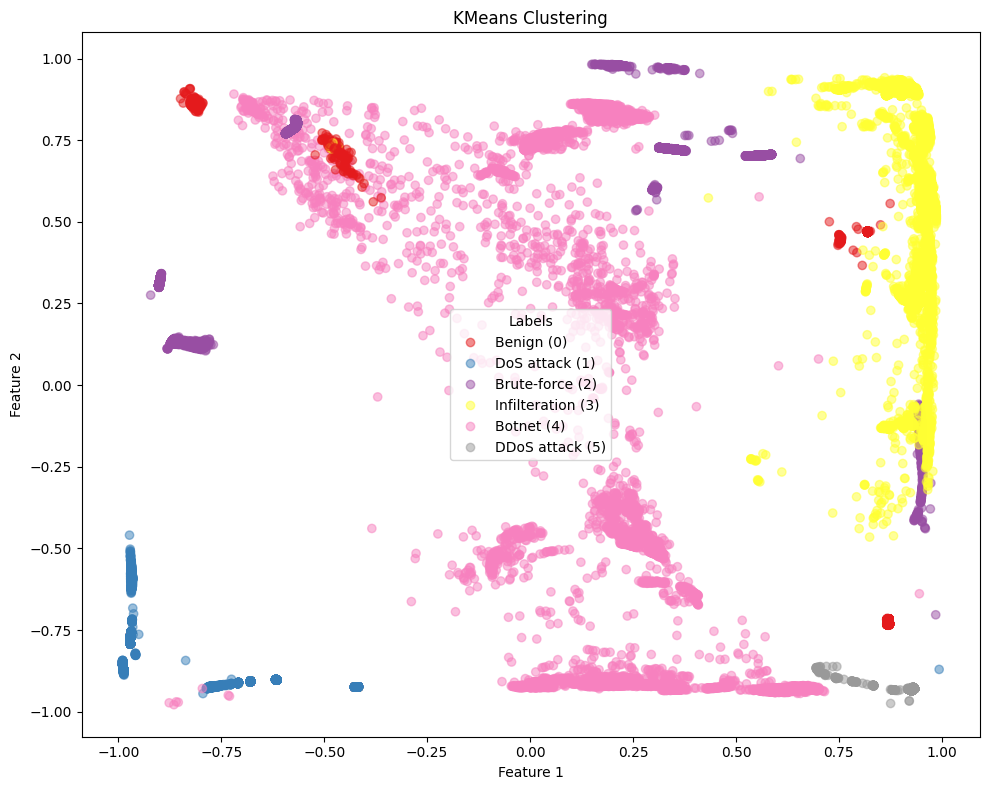

In [199]:
import numpy as np
from sklearn.cluster import KMeans  # Change here
import matplotlib.pyplot as plt

# Extract data from the dictionary
data = []
labels = []

for label, tensors in compressed_outs.items():
    for tensor in tensors:
        data.append(tensor.detach().numpy())
        labels.append(label)

data = np.array(data)

# Apply KMeans clustering  # Change here
kmeans = KMeans(n_clusters=len(sel_labels), random_state=42)  # You may need to adjust the number of clusters
cluster_labels = kmeans.fit_predict(data)

# Create a larger figure
fig, ax = plt.subplots(figsize=(10, 8))

# Visualize the clusters with different colors for each label
scatter = ax.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='Set1', alpha=0.5)

# Add legend with label names only if there are valid elements
if scatter.legend_elements()[0] is not None and len(scatter.legend_elements()[0]) > 0:
    unique_labels = list(set(labels))
    legend_labels = [f'{label} ({i})' for i, label in enumerate(unique_labels)]
    ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Labels')

ax.set_title('KMeans Clustering')  # Change here
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')

plt.tight_layout()  # Adjust layout

plt.show()

In [78]:
proc = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = compressed_outs['Botnet'][0].shape[0]
classify = len(compressed_outs.keys())

class GlobalModel(nn.Module):
    def __init__(self, input_dim):
        super(GlobalModel, self).__init__()
        
        xavier_gain = nn.init.calculate_gain('tanh')
        
        self.fc1 = nn.Linear(input_dim, 24)
        self.fc2 = nn.Linear(24, 32)
        self.fc3 = nn.Linear(32, 48)
        self.fc4 = nn.Linear(48, 69)
        self.fc5 = nn.Linear(69, 32)
        self.fc6 = nn.Linear(32, 18)
        self.fc7 = nn.Linear(18, classify)
       
        self.activation = nn.Tanh()
        nn.init.xavier_uniform_(self.fc1.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc2.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc3.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc4.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc5.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc6.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc7.weight, gain=xavier_gain)

        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x)
        x = self.fc6(x)
        x = self.activation(x)
        x = self.fc7(x)
        return x

global_model = GlobalModel(input_dim).to(proc)
opt= torch.optim.SGD(global_model.parameters(), lr = 0.012, weight_decay=1e-05,momentum=0.9)

In [79]:
def global_update(global_model, optimizer, train_data, target_labels, epoch):
    for e in range(epoch):
        running_loss = 0.0
        prev = 0
        ind = 128
        for data in train_data:
          global_model.train()
          output = global_model(data.float()) # tensor 115
          optimizer.zero_grad()
          global_model.eval()
          # criterion = nn.MSELoss(reduction='mean')
          # loss = criterion(data.to(proc), output)
          target_label = torch.Tensor(target_labels[prev:ind])
          loss = nn.CrossEntropyLoss()(output, target_label)
          loss.backward()
          optimizer.step()
          # print(loss.item())
          running_loss += loss.item()
          prev = ind
          ind += 128
          if ind > len(target_labels):
            ind = len(target_labels)
        # print(running_loss)
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss

In [80]:
epochs = 10
batch_size = 128

In [81]:
import random

detached_tensors = []
detached_labels = []

# Iterate through the tensors and detach them
for key, tensor_list in compressed_outs.items():
    for tensor in tensor_list:
        detached_labels.append(dikt[key])
        dt = tensor.detach().numpy()  # Detach from computation graph and convert to NumPy array if needed
        detached_tensors.append(dt)

idxs = list(range(len(detached_tensors)))
# Shuffle the indices
idxs = shuffle(idxs)

# Use the indices to shuffle the tensors and labels
shuffled_tensors = [detached_tensors[i] for i in idxs] 
shuffled_labels = [detached_labels[i] for i in idxs]

shuffled_data_loader = DataLoader(shuffled_tensors, batch_size=batch_size)

In [82]:
loss = global_update(global_model, opt, shuffled_data_loader, shuffled_labels, epochs)
print(loss)

0.0008136589463099218


In [83]:
torch.save(global_model, 'models16/globalattackmodel.pt')

In [84]:
global_model = torch.load('models16/globalattackmodel.pt')

In [85]:
detached_tensors_test = []
detached_labels_test= []

# Iterate through the tensors and detach them
for key, tensor_list in compressed_outs_test.items():
    for tensor in tensor_list:
        detached_labels_test.append(dikt[key])
        dt = tensor.detach().numpy()  # Detach from computation graph and convert to NumPy array if needed
        detached_tensors_test.append(dt)

In [86]:
labels = []
for i in detached_labels_test:
    labels.append(i.index(1))
print(len(labels))

60000


<Axes: >

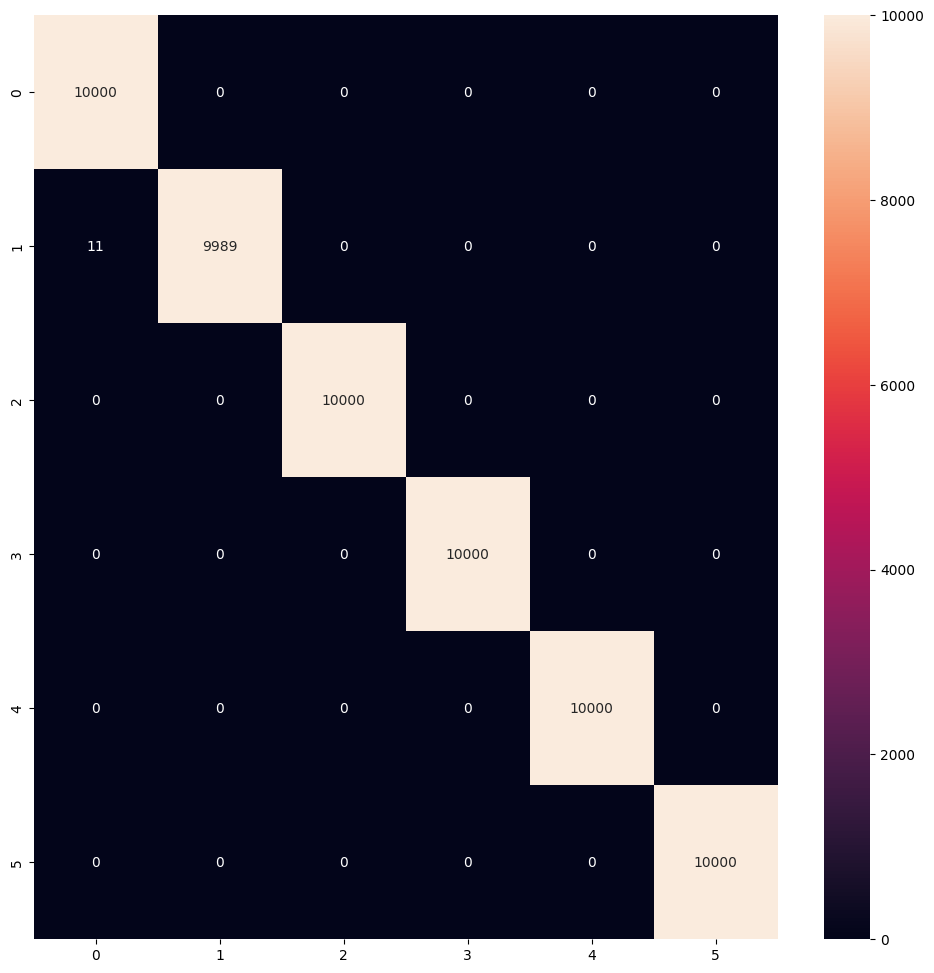

In [87]:
from sklearn.metrics import confusion_matrix
model = global_model
model.eval()
temp_test = []
temp = []
for data in detached_tensors_test:
    data = torch.Tensor(data).reshape(1,-1)
    pred = nn.Softmax(dim=1)(model(data).float())
    temp.append(pred)
    pred = pred.argmax(dim=1)
    temp_test.append(pred)
cm = confusion_matrix(labels, temp_test)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='g')

In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming you have the confusion matrix stored in the variable 'cm'
# Calculate accuracy
accuracy = accuracy_score(labels, temp_test)

# Calculate precision, recall, and F1 score for each class
precision = precision_score(labels, temp_test, average='weighted')
recall = recall_score(labels, temp_test, average='weighted')
f1 = f1_score(labels, temp_test, average='weighted')

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR) for each class
TPR = []
FPR = []
for i in range(cm.shape[0]):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FN - FP
    TPR.append(TP / (TP + FN))
    FPR.append(FP / (FP + TN))

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TPR:", TPR)
print("FPR:", FPR)

Accuracy: 0.9998166666666667
Precision: 0.9998168681117436
Recall: 0.9998166666666667
F1 Score: 0.9998166666112084
TPR: [1.0, 0.9989, 1.0, 1.0, 1.0, 1.0]
FPR: [0.00022, 0.0, 0.0, 0.0, 0.0, 0.0]


In [89]:
dikt

{'Benign': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DDoS attack': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 'DoS attack': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 'Brute-force': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 'Botnet': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 'Infilteration': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]}

In [90]:
compressed_mixed = {}
j=0
for data in mixed_data:
    if j<100:
        for i in client_models:
            model = client_models[i]
            model.eval()
            layer_output = model(torch.Tensor(data))
            try:
                compressed_mixed[i].append(layer_output)
            except:
                compressed_mixed[i] = [layer_output]
    j+=1

In [91]:
mixed_data_labels

['Infilteration',
 'Infilteration',
 'DDoS attack',
 'DDoS attack',
 'Infilteration',
 'DoS attack',
 'Botnet',
 'Brute-force',
 'Benign',
 'DoS attack',
 'Infilteration',
 'Infilteration',
 'Benign',
 'Botnet',
 'Brute-force',
 'Benign',
 'Benign',
 'Benign',
 'Brute-force',
 'DoS attack',
 'DoS attack',
 'Botnet',
 'Brute-force',
 'DDoS attack',
 'Benign',
 'Brute-force',
 'Infilteration',
 'Benign',
 'Infilteration',
 'DDoS attack',
 'Benign',
 'DoS attack',
 'DoS attack',
 'Brute-force',
 'DoS attack',
 'Botnet',
 'DDoS attack',
 'Benign',
 'Infilteration',
 'Botnet',
 'DDoS attack',
 'Botnet',
 'Brute-force',
 'DoS attack',
 'Brute-force',
 'DDoS attack',
 'DoS attack',
 'DDoS attack',
 'Botnet',
 'Brute-force',
 'DDoS attack',
 'Benign',
 'Botnet',
 'DoS attack',
 'DDoS attack',
 'Infilteration',
 'Benign',
 'Brute-force',
 'Botnet',
 'DoS attack',
 'DoS attack',
 'Brute-force',
 'Botnet',
 'DoS attack',
 'Brute-force',
 'DoS attack',
 'Benign',
 'Brute-force',
 'Botnet',
 'Botne

In [92]:
len(mixed_data_labels_encoded)

60000

In [93]:
len(compressed_mixed)

6

In [94]:
compressed_mixed.keys()

dict_keys(['Benign', 'DDoS attack', 'DoS attack', 'Brute-force', 'Botnet', 'Infilteration'])

In [95]:
len(compressed_mixed['Botnet'])

100

In [96]:
global_model.eval()
preds = {}
for i in range(len(compressed_mixed['Botnet'])):
    client_preds = []
    for key in compressed_mixed:
            data = compressed_mixed[key][i]
            data = torch.Tensor(data).reshape(1,-1)
            pred = nn.Softmax(dim=1)(global_model(data).float())
            #client_preds.append(pred)
            client_preds.append(int(pred.argmax(dim=1)))
    preds[i] = client_preds

In [97]:
len(preds)

100

In [98]:
labdikts = {}
for i in range(len(preds)):
    label = mixed_data_labels_encoded[i].index(1)
    try:
        labdikts[label].append(preds[i])
    except:
        labdikts[label] = [preds[i]]

In [99]:
from collections import Counter
c = Counter([8, 8, 2, 8, 4, 1, 6, 0])
for i in c:
    print(i, c[i])

8 3
2 1
4 1
1 1
6 1
0 1


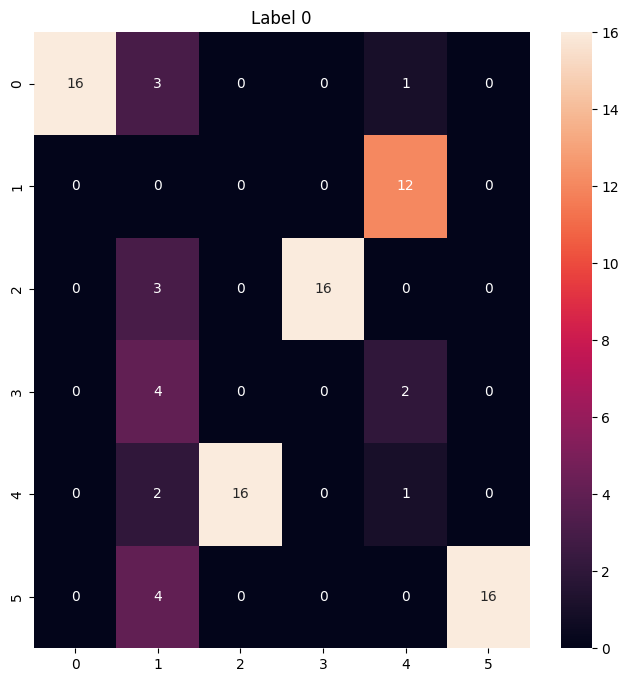

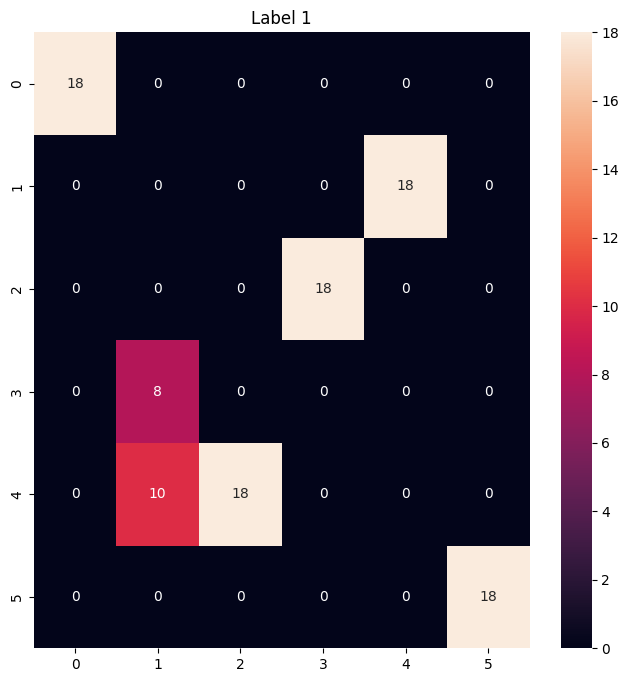

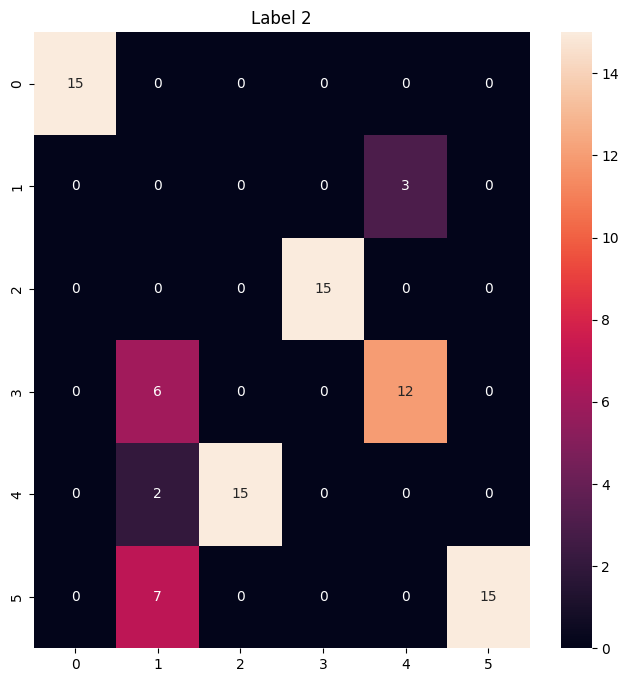

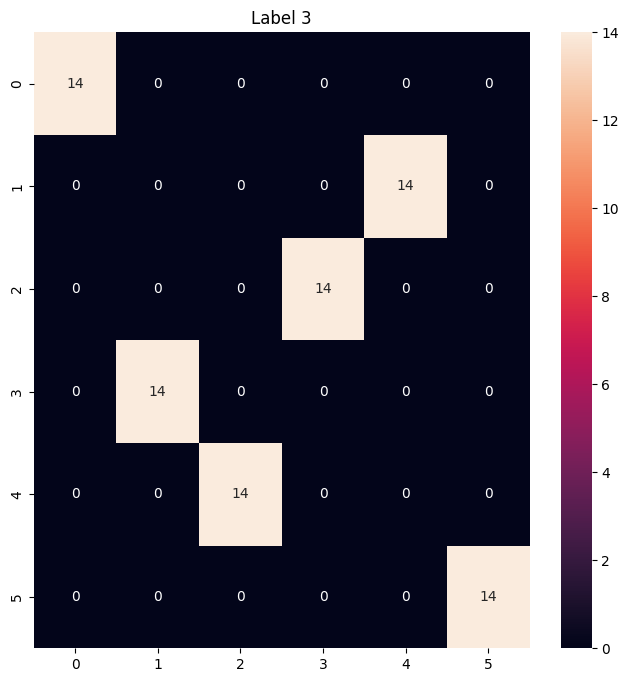

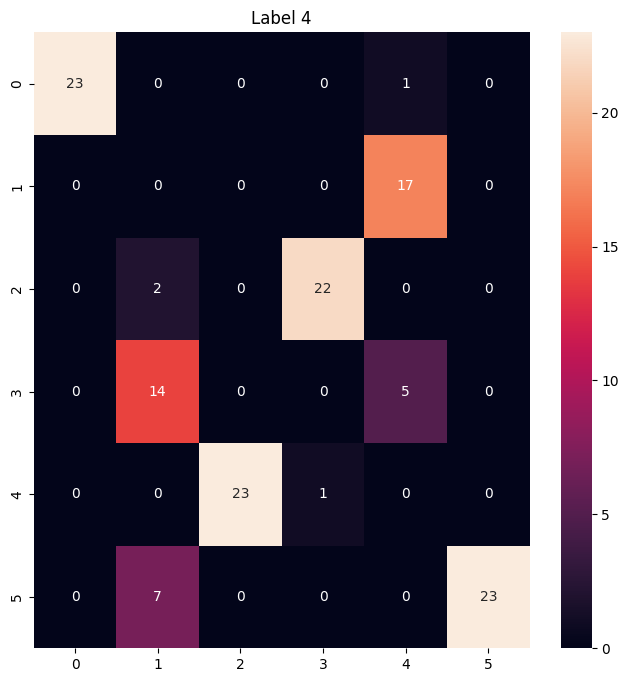

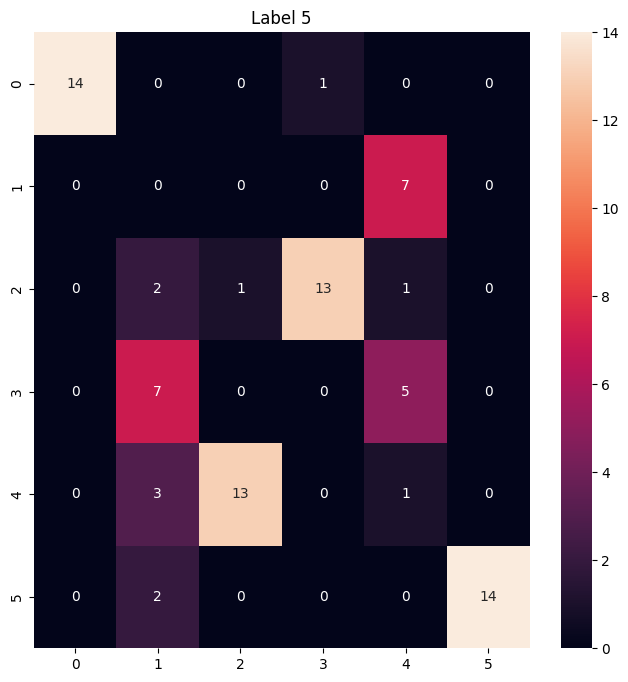

In [100]:
from collections import Counter
for i in range(6):
    arr = np.array(labdikts[i])
    mat = np.zeros((6, 6))
    for j in range(arr.shape[1]):
        c = Counter(arr[:, j])
        for k in c:
            mat[k, j] = c[k]
    plt.figure(figsize=(8, 8))
    plt.title("Label " + str(i))
    plt.ylabel("Predicted")
    plt.xlabel("Clients")
    sns.heatmap(mat, annot=True, fmt='g')     
    plt.show()

In [73]:
for i in range(len(preds)):
    print(preds[i], mixed_data_labels_encoded[i].index(1))

[0, 4, 4, 2, 1, 5] 5
[0, 3, 4, 2, 3, 5] 5
[0, 3, 4, 2, 1, 5] 3
[0, 3, 4, 2, 1, 5] 3
[0, 3, 3, 2, 1, 5] 5
[0, 3, 4, 2, 1, 5] 4
[0, 3, 4, 2, 1, 5] 1
[0, 3, 4, 2, 1, 5] 2
[0, 5, 4, 4, 1, 5] 0
[0, 3, 4, 2, 1, 5] 4
[0, 3, 4, 2, 1, 5] 5
[0, 3, 4, 2, 1, 5] 5
[0, 3, 4, 2, 4, 5] 0
[0, 3, 4, 2, 1, 5] 1
[0, 1, 4, 2, 4, 5] 2
[0, 4, 4, 2, 4, 5] 0
[0, 3, 3, 2, 1, 5] 0
[0, 3, 4, 2, 1, 5] 0
[0, 3, 4, 2, 1, 5] 2
[0, 5, 4, 2, 4, 5] 4
[0, 5, 4, 2, 4, 5] 4
[0, 4, 4, 2, 1, 5] 1
[0, 3, 4, 2, 1, 5] 2
[0, 3, 4, 2, 1, 5] 3
[0, 2, 0, 2, 1, 5] 0
[0, 1, 4, 2, 3, 5] 2
[0, 4, 4, 2, 1, 5] 5
[0, 3, 4, 2, 1, 5] 0
[0, 3, 4, 2, 1, 5] 5
[0, 3, 0, 2, 1, 5] 3
[0, 3, 4, 2, 1, 5] 0
[0, 3, 4, 2, 1, 5] 4
[0, 5, 4, 2, 4, 5] 4
[0, 1, 4, 2, 4, 5] 2
[0, 3, 4, 2, 1, 5] 4
[0, 3, 4, 2, 1, 5] 1
[0, 3, 4, 2, 1, 5] 3
[0, 1, 4, 2, 1, 5] 0
[0, 4, 4, 0, 0, 5] 5
[0, 4, 0, 2, 1, 5] 1
[0, 3, 4, 2, 1, 5] 3
[0, 4, 0, 2, 1, 5] 1
[0, 4, 4, 2, 4, 5] 2
[0, 3, 4, 2, 1, 5] 4
[0, 1, 4, 2, 4, 5] 2
[0, 3, 0, 2, 1, 5] 3
[0, 3, 4, 2, 1, 5] 4
[0, 3, 4, 2, 

In [74]:
count=0
from collections import Counter
for i in range(len(preds)):
    if Counter(preds[i]).most_common(1)[0][0]== mixed_data_labels_encoded[i].index(1):
        count+=1

In [118]:
count

34

In [99]:
len(preds)

90000

TRIAL Decision Tree


In [190]:
#noise
X = []
Y = []

for i in client_models:
    model = client_models[i]
    model.__class__.forward = forward
    model.eval()
    dataloader = train_loader[i]
    outs = []
    ind = 0
    flag = False
    for batch in dataloader:
        for data in batch:
            if ind<5000:
                layer_output = model(data.float())
                outs.append(layer_output)
                X.append(layer_output.detach().numpy())
                Y.append(i)
            ind += 1
            

In [191]:
# split the data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.1, random_state =42, shuffle=True)

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [110]:
%%time
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00       485
       Botnet       1.00      1.00      1.00       507
  Brute-force       1.00      1.00      1.00       482
  DDoS attack       1.00      1.00      1.00       510
   DoS attack       1.00      1.00      1.00       535
Infilteration       1.00      1.00      1.00       481

     accuracy                           1.00      3000
    macro avg       1.00      1.00      1.00      3000
 weighted avg       1.00      1.00      1.00      3000

CPU times: total: 156 ms
Wall time: 313 ms


In [148]:
len(preds)

100

In [149]:
import numpy as np
res={}
for i in client_models:
    for j in range(len(preds)):
        out=dtc.predict(np.array(compressed_mixed[i][j].detach().numpy()).reshape(1, -1))
        try:
            res[i].append(out)
        except:
            res[i] = [out]

# Now, you can use the resha

In [150]:
res

{'Benign': [array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['Benign'], dtype='<U13'),
  array(['

In [133]:
mixed_data_labels

['Infilteration',
 'Infilteration',
 'DDoS attack',
 'DDoS attack',
 'Infilteration',
 'DoS attack',
 'Botnet',
 'Brute-force',
 'Benign',
 'DoS attack',
 'Infilteration',
 'Infilteration',
 'Benign',
 'Botnet',
 'Brute-force',
 'Benign',
 'Benign',
 'Benign',
 'Brute-force',
 'DoS attack',
 'DoS attack',
 'Botnet',
 'Brute-force',
 'DDoS attack',
 'Benign',
 'Brute-force',
 'Infilteration',
 'Benign',
 'Infilteration',
 'DDoS attack',
 'Benign',
 'DoS attack',
 'DoS attack',
 'Brute-force',
 'DoS attack',
 'Botnet',
 'DDoS attack',
 'Benign',
 'Infilteration',
 'Botnet',
 'DDoS attack',
 'Botnet',
 'Brute-force',
 'DoS attack',
 'Brute-force',
 'DDoS attack',
 'DoS attack',
 'DDoS attack',
 'Botnet',
 'Brute-force',
 'DDoS attack',
 'Benign',
 'Botnet',
 'DoS attack',
 'DDoS attack',
 'Infilteration',
 'Benign',
 'Brute-force',
 'Botnet',
 'DoS attack',
 'DoS attack',
 'Brute-force',
 'Botnet',
 'DoS attack',
 'Brute-force',
 'DoS attack',
 'Benign',
 'Brute-force',
 'Botnet',
 'Botne

TRIAL 2

In [152]:
import numpy as np
import pandas as pd
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [153]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [187]:
dikt

{'Benign': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DDoS attack': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 'DoS attack': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 'Brute-force': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 'Botnet': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 'Infilteration': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]}

In [192]:
for x in range(len(y_train)):
    y_train[x]=dikt[y_train[x]].index(1)

In [195]:
for x in range(len(y_pred)):
    y_pred[x]=dikt[y_pred[x]].index(1)

In [193]:
set(y_train)

{0, 1, 2, 3, 4, 5}

In [194]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

model = XGBClassifier(n_estimators=100)
%time
model.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [197]:
import numpy as np
res={}
for i in client_models:
    for j in range(len(preds)):
        out=model.predict(np.array(compressed_mixed[i][j].detach().numpy()).reshape(1, -1))
        try:
            res[i].append(out)
        except:
            res[i] = [out]

# Now, you can use the resha

In [198]:
res

{'Benign': [array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype